Source: [U-Net: Training Image Segmentation Models in PyTorch](https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/)

In [2]:
import os
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
from unet import Unet

In [3]:
class SegmentationDataset(Dataset):

    def __init__(self, path_images, path_masks, files, scale_x=255, scale_y=65535, transform=None):
        
        self.path_images = path_images
        self.path_masks = path_masks
        self.files = files
        self.scale_x = scale_x
        self.scale_y = scale_y
        self.transform = transform
    
    def __len__(self):
        
        return len(self.files)
    
    def __getitem__(self,index):
        
        img = Image.open(os.path.join(self.path_images, self.files[index]))
        img_mask = Image.open(os.path.join(self.path_masks, self.files[index]))

        if self.transform:
            sample = np.asanyarray(self.transform(img))
        else:
            sample = np.asanyarray(img)

        sample = sample[:,:,:3]
        sample = sample/self.scale_x

        label = np.asanyarray(img_mask)
        label = label/self.scale_y
        label = np.expand_dims(label,2)

        sample = torch.tensor(np.transpose(sample, (2,0,1)), dtype=torch.float)
        label = torch.tensor(np.transpose(label, (2,0,1)), dtype=torch.float)
        
        return sample, label

In [4]:
def plot_sample(dataset, index):
    
    (x, y) = dataset[index]
        
    img = (np.transpose(x.numpy(), (1,2,0)))
    img = Image.fromarray((255*img).astype(np.uint8))
    img_mask = (np.transpose(y.numpy(), (1,2,0)))
    img_mask = Image.fromarray((255*img_mask[:,:,0]).astype(np.uint8))
    
    _, axs = plt.subplots(1,2, figsize=(3.5,3.5))
    axs[0].imshow(img, interpolation='nearest')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(img_mask, interpolation='nearest')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    return img, img_mask

# Setup the datasets

In [5]:
path_data = './data/Unet_data/train'
path_images = os.path.join(path_data, 'images')
path_masks = os.path.join(path_data, 'masks')

In [6]:
test_size = 0.15
seed_split = 42
batch_size = 50

In [7]:
files = os.listdir(path_images)
[train_files, test_files] = train_test_split(files, test_size=test_size, random_state=seed_split)

train_dataset = SegmentationDataset(path_images, path_masks, train_files, scale_x=255, scale_y=65535, transform=None)
test_dataset = SegmentationDataset(path_images, path_masks, test_files, scale_x=255, scale_y=65535, transform=None)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

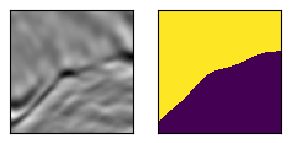

In [8]:
img, img_mask = plot_sample(train_dataset, index=134)

# make model

![Alt text](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/11/unet_small.png?lossy=1&strip=1&webp=1)

In [9]:
x=torch.unsqueeze(train_dataset[0][0],0)
x.shape

torch.Size([1, 3, 101, 101])

In [10]:
model = Unet(cin=3, features=[32, 64, 128, 256], num_classes=1)

In [11]:
out = model(x)

In [12]:
out.shape

torch.Size([1, 1, 101, 101])